In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langgraph_sdk langgraph-prebuilt

In [2]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

### added my own tools

In [3]:
from langchain_openai import ChatOpenAI
import math

def add(a: int, b: int) -> int:
    """Add two integers.

    Args:
        a: First integer
        b: Second integer

    Returns:
        Sum of a and b
    """
    return a + b

def subtract(a: int, b: int) -> int:
    """Subtract b from a.

    Args:
        a: First integer
        b: Second integer

    Returns:
        Result of a - b
    """
    return a - b

def multiply(a: int, b: int) -> int:
    """Multiply two integers.

    Args:
        a: First integer
        b: Second integer

    Returns:
        Product of a and b
    """
    return a * b

def divide(a: int, b: int) -> float:
    """Divide a by b.

    Args:
        a: Dividend
        b: Divisor

    Returns:
        Result of a / b
    """
    return a / b

def exponent(a: int, b: int) -> int:
    """Raise a to the power of b.

    Args:
        a: Base integer
        b: Exponent integer

    Returns:
        a raised to the power b
    """
    return a ** b

def factorial(n: int) -> int:
    """Calculate factorial of n.

    Args:
        n: An integer (should be >= 0)

    Returns:
        Factorial of n
    """
    return math.factorial(n)

def modulus(a: int, b: int) -> int:
    """Compute a modulo b.

    Args:
        a: Dividend
        b: Divisor

    Returns:
        Remainder after dividing a by b
    """
    return a % b

def integer_division(a: int, b: int) -> int:
    """Integer division (floor division) of a by b.

    Args:
        a: Dividend
        b: Divisor

    Returns:
        Quotient of a // b
    """
    return a // b

tools = [
    add,
    subtract,
    multiply,
    divide,
    exponent,
    factorial,
    modulus,
    integer_division
]

llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools(tools)


### created a graph with interrupt before the assisstant call

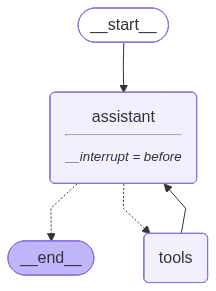

In [4]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode

from langchain_core.messages import HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine the control flow
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

memory = MemorySaver()
graph = builder.compile(interrupt_before=["assistant"], checkpointer=memory)

# Show
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

### we can take a look at this in the langgraph studio :

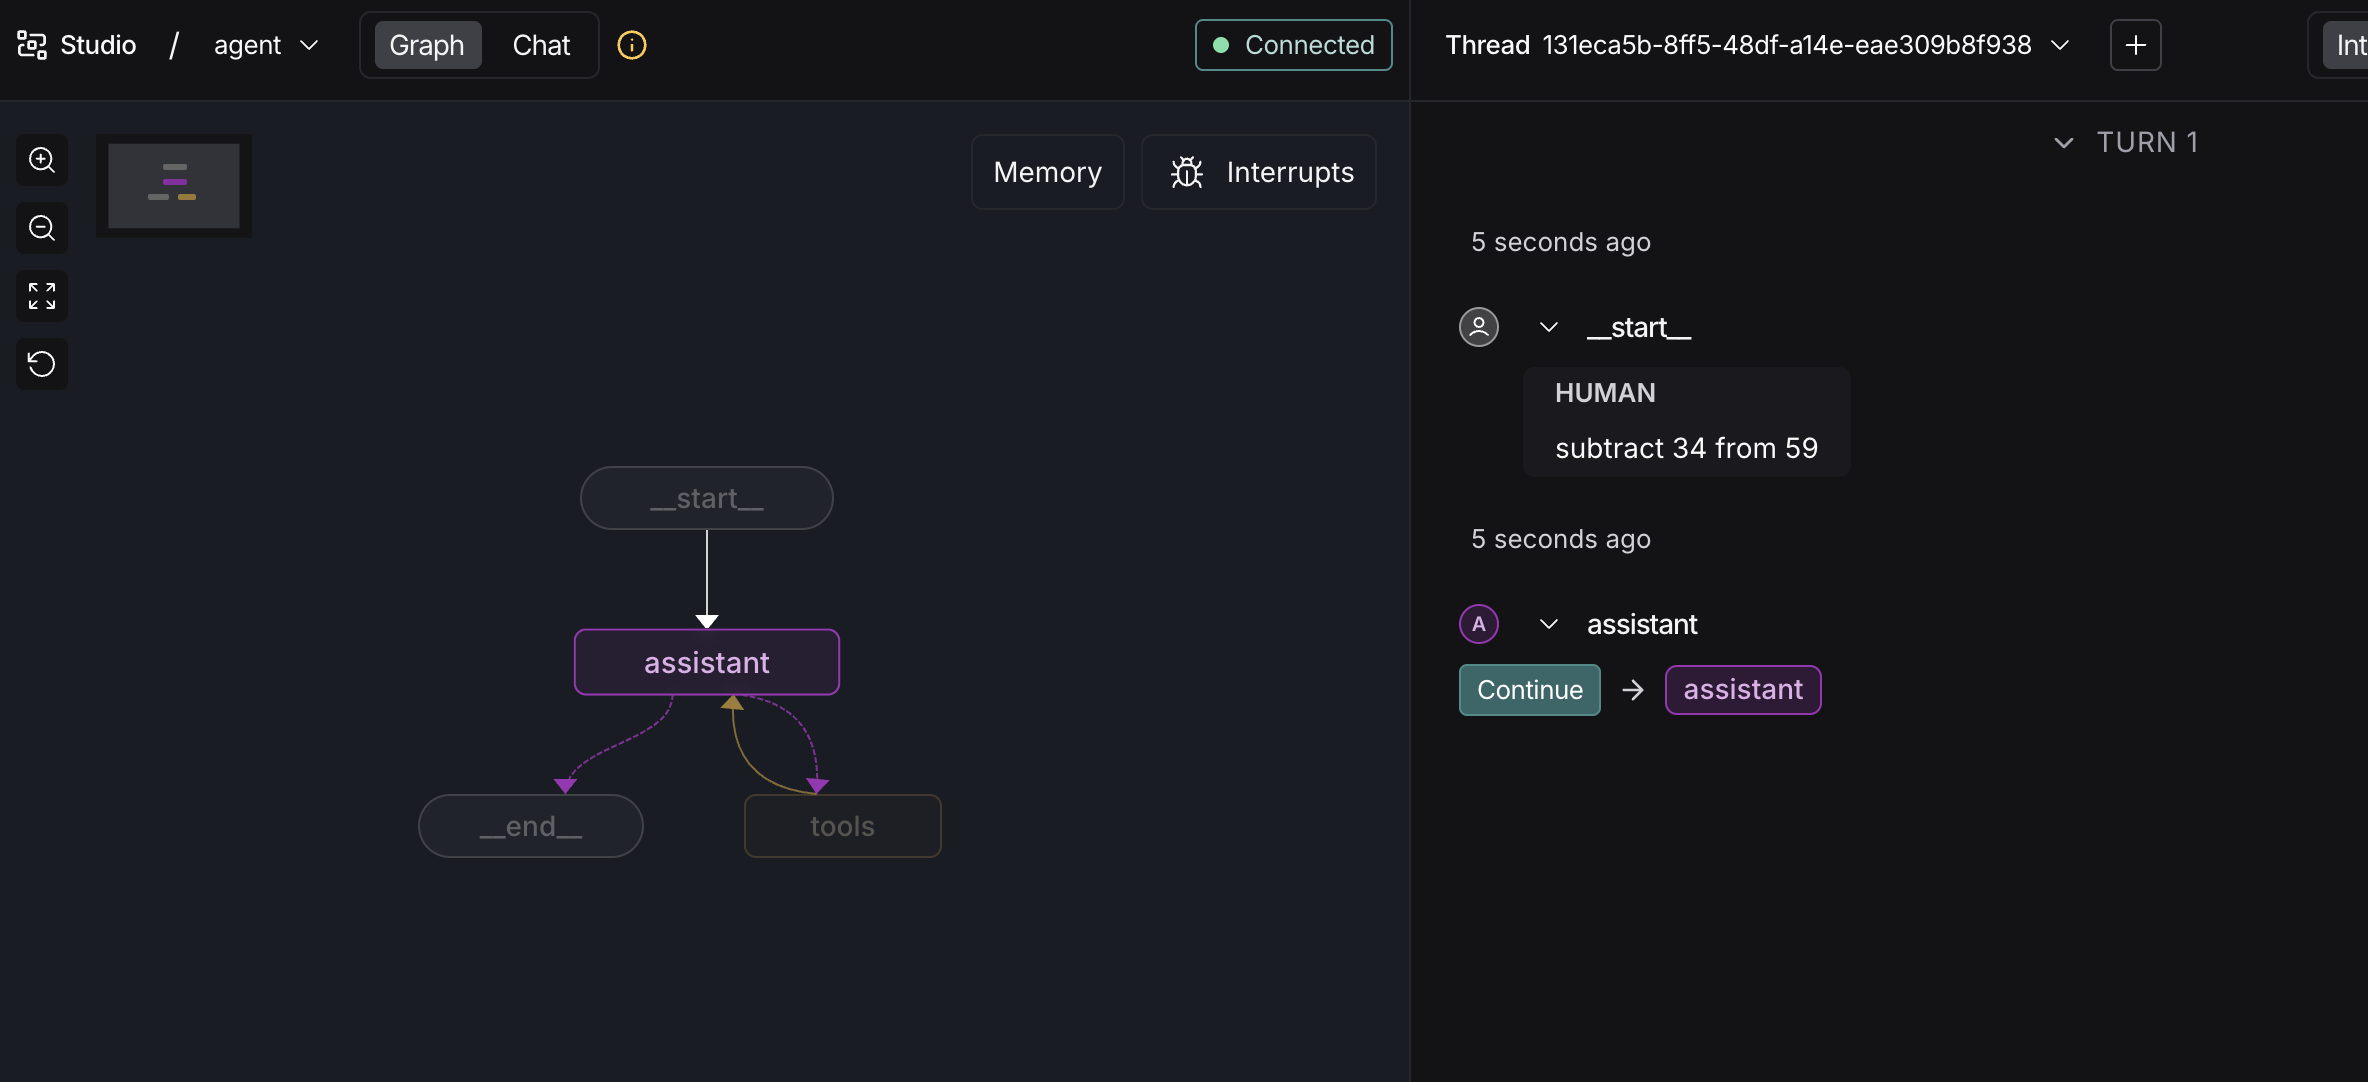

### we get the option to edit the node : 

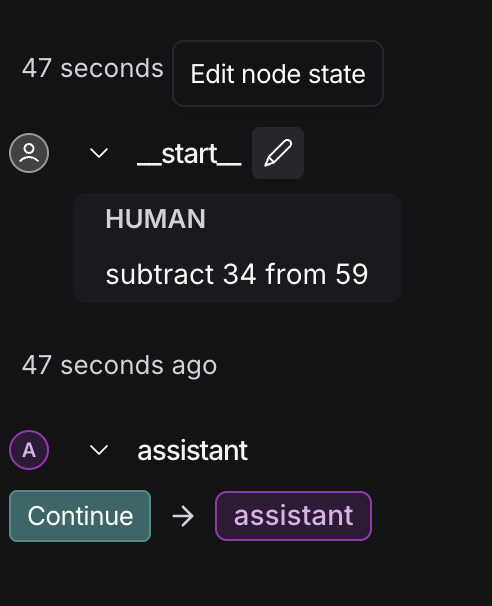

### and then we can fork the edits : 

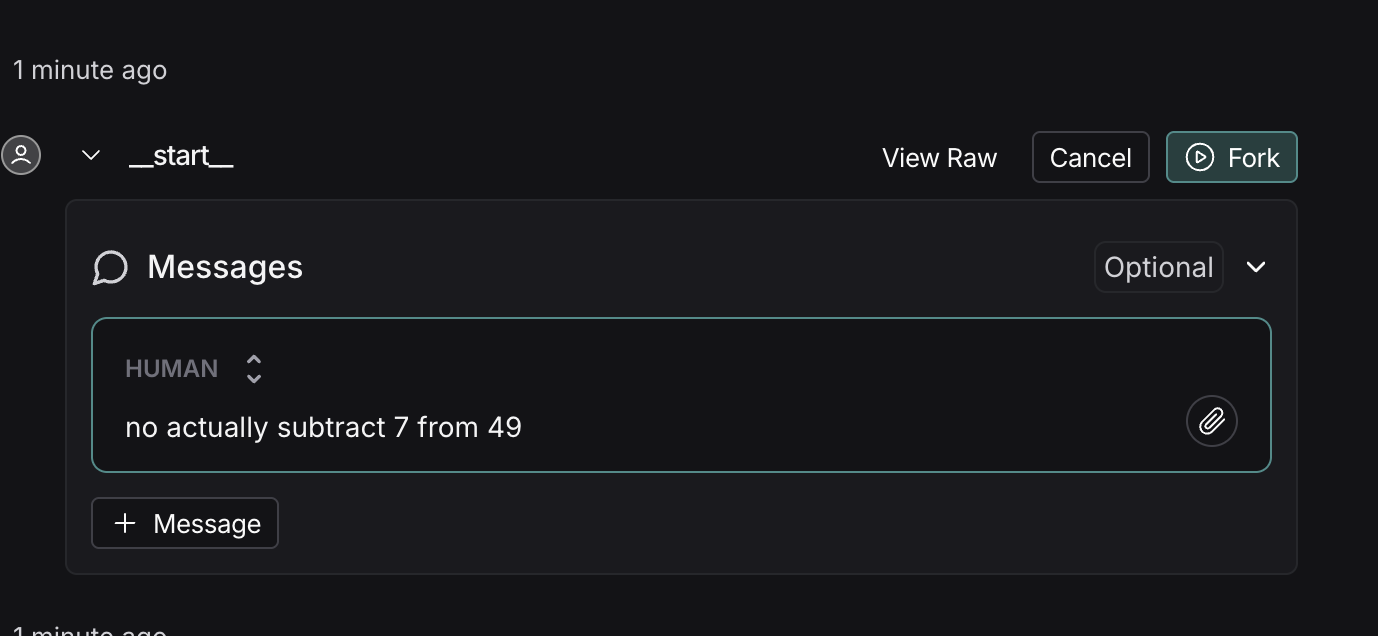

#### we get this result : 
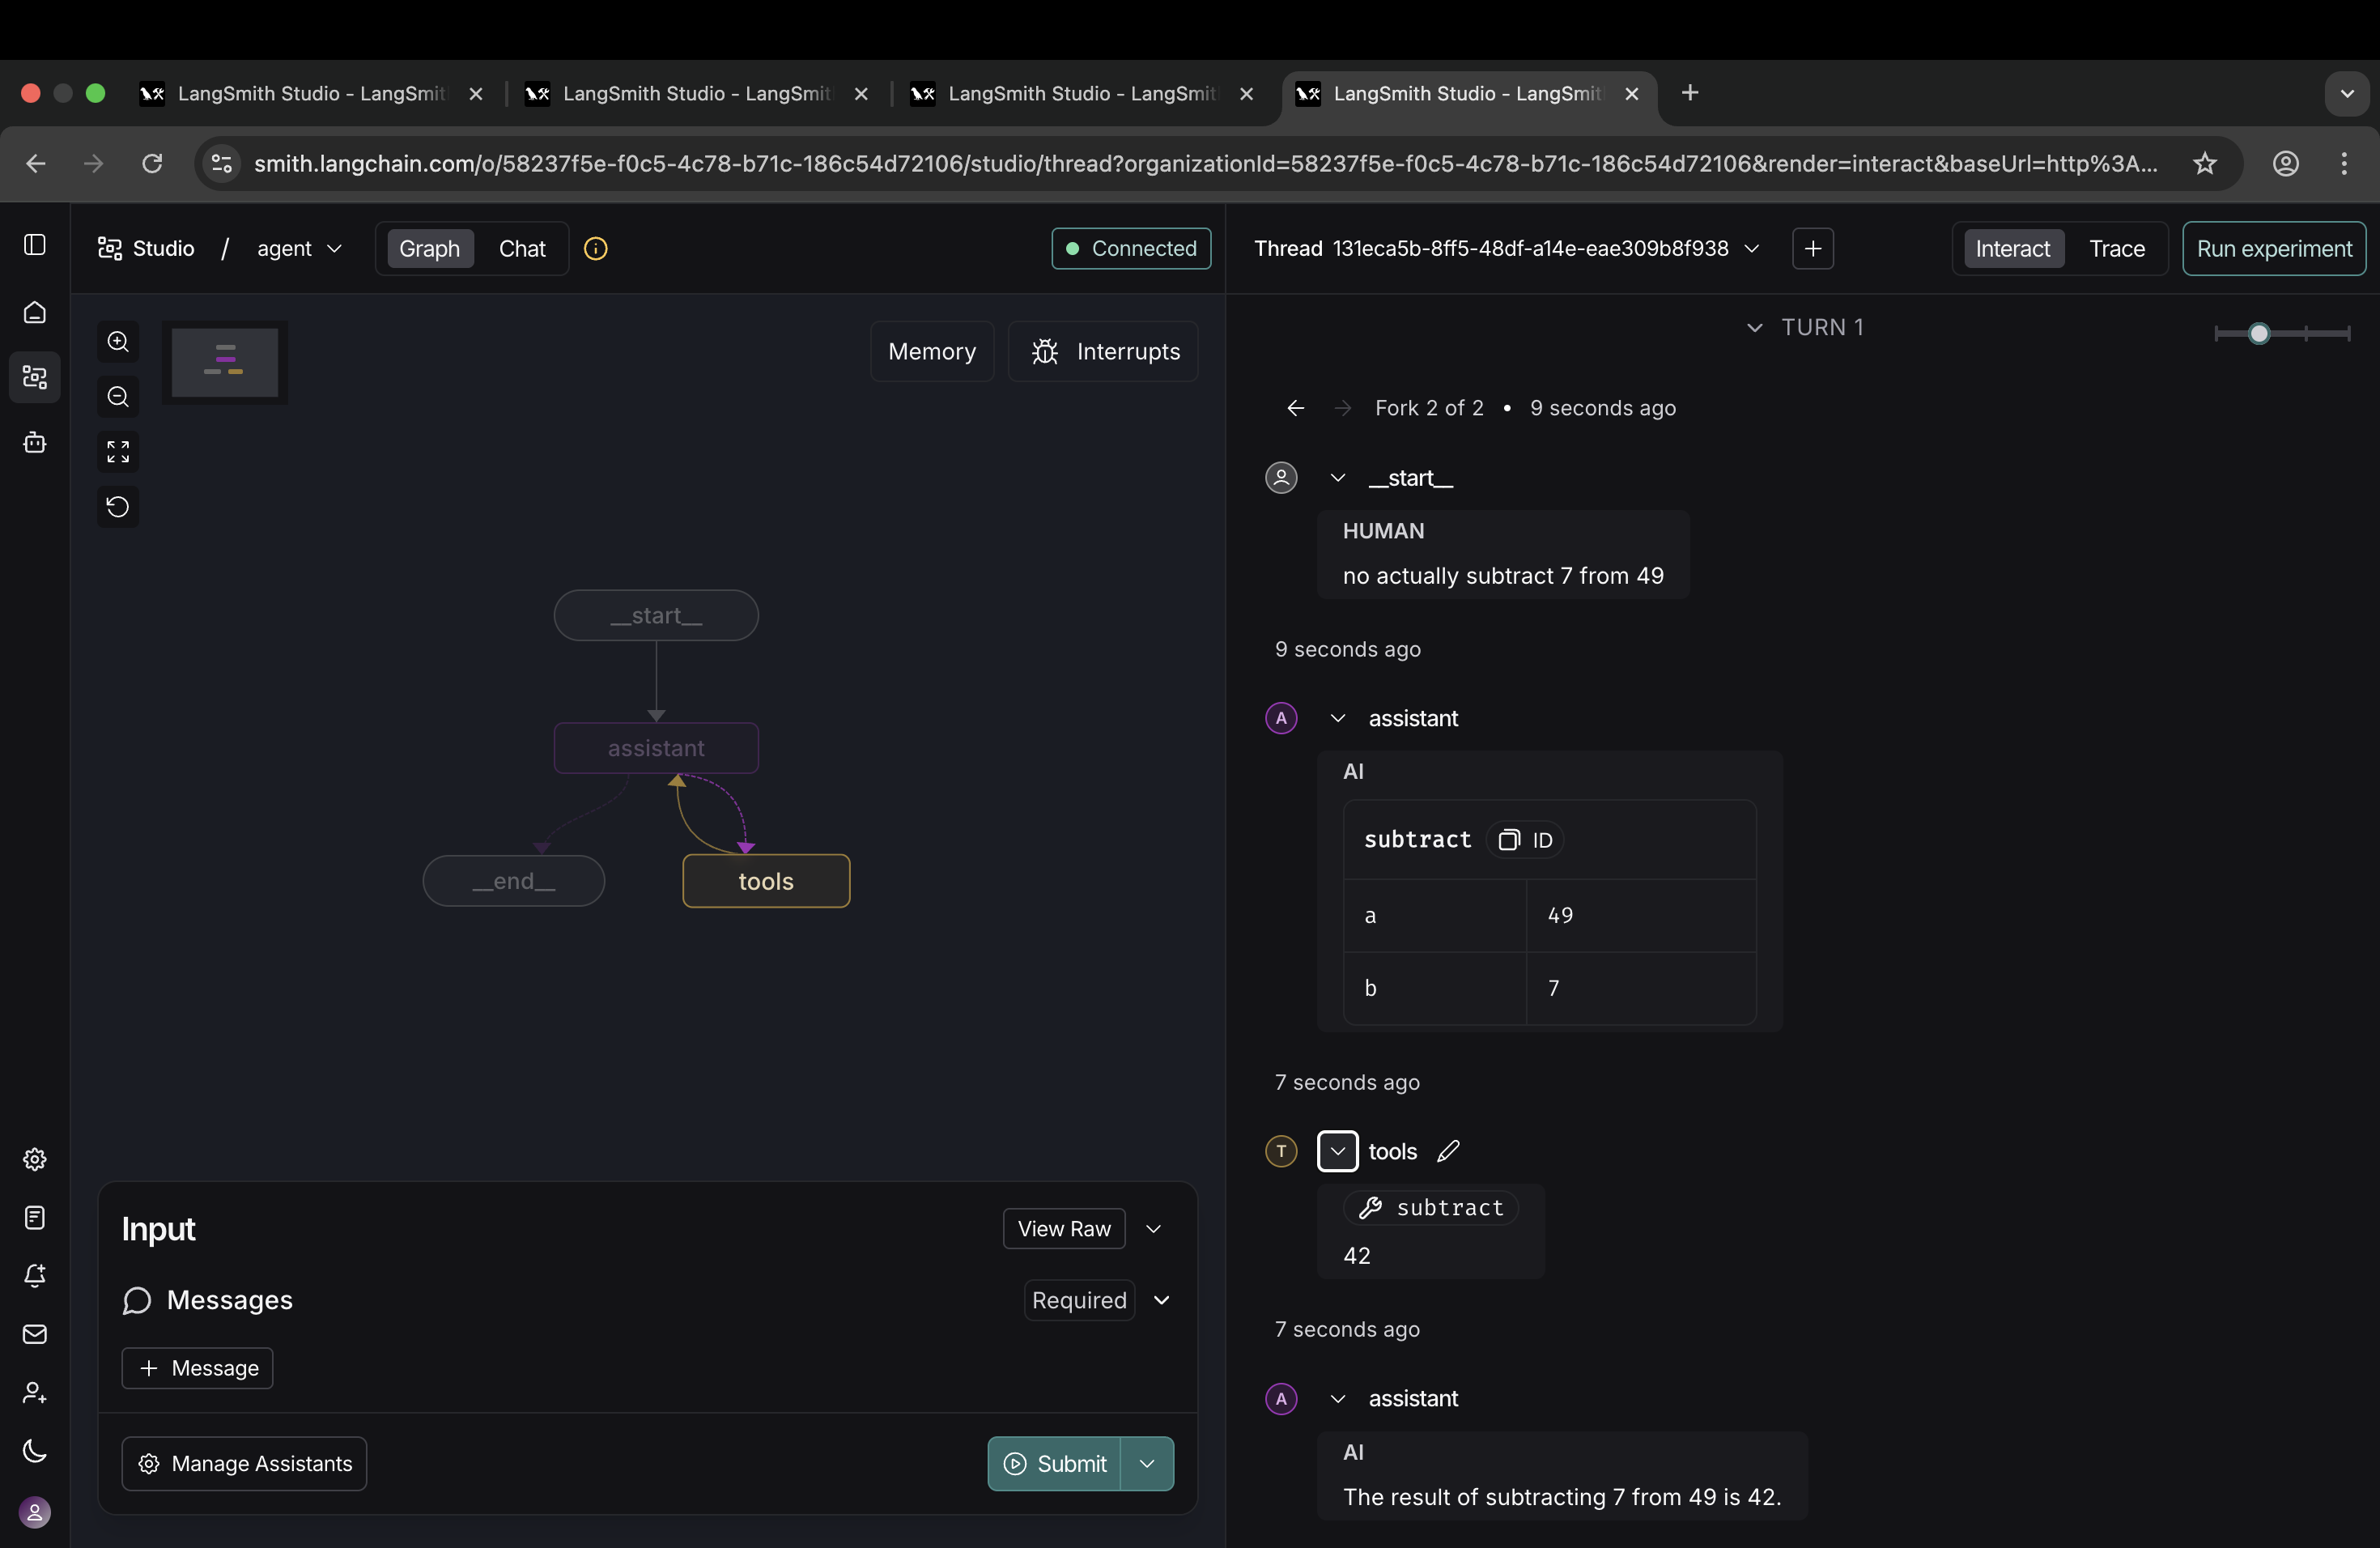

## example 1

In [5]:
# Input
initial_input = {"messages": "raise 5 to the power of 3"}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

raise 5 to the power of 3


In [6]:
state = graph.get_state(thread)
state

StateSnapshot(values={'messages': [HumanMessage(content='raise 5 to the power of 3', additional_kwargs={}, response_metadata={}, id='cdb4bd29-4fbb-4809-bbf7-c4b4ddeb1f0f')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0b339b-019c-6730-8000-0b8ea067e9a5'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}}, created_at='2025-10-27T13:34:39.747250+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0b339b-0199-6922-bfff-2d6133f7d7c3'}}, tasks=(PregelTask(id='28d631b2-3606-314f-1741-5e580e3ce82e', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result=None),), interrupts=())

#### we can see that in the upper cell that the graph gets interrupted before the assistant node call , now here I have updated th state 

In [7]:
graph.update_state(
    thread,
    {"messages": [HumanMessage(content="No, actually integer divide 11 by 3")]},
)
new_state = graph.get_state(thread).values
for m in new_state['messages']:
    m.pretty_print()

================================ Human Message =================================

raise 5 to the power of 3
================================ Human Message =================================

No, actually integer divide 11 by 3


### now after updating i continued to print the final output 

In [8]:
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

No, actually integer divide 11 by 3
================================== Ai Message ==================================
Tool Calls:
  integer_division (call_rxjCIjJshvaZR9vQwiRsJgHA)
 Call ID: call_rxjCIjJshvaZR9vQwiRsJgHA
  Args:
    a: 11
    b: 3
================================= Tool Message =================================
Name: integer_division

3
================================= Tool Message =================================
Name: integer_division

3
================================== Ai Message ==================================

The result of integer division of 11 by 3 is 3.


## example2 

In [9]:
# Input
initial_input = {"messages": "raise 3 to the power of 3"}

# Thread
thread = {"configurable": {"thread_id": "2"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

raise 3 to the power of 3


In [10]:
graph.update_state(
    thread,
    {"messages": [HumanMessage(content="No, actually calculate 4 factorial")]},
)
new_state = graph.get_state(thread).values
for m in new_state['messages']:
    m.pretty_print()

================================ Human Message =================================

raise 3 to the power of 3
================================ Human Message =================================

No, actually calculate 4 factorial


In [11]:
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

No, actually calculate 4 factorial
================================== Ai Message ==================================
Tool Calls:
  factorial (call_bQdGFtk0NScvriSTHT0UA7Aa)
 Call ID: call_bQdGFtk0NScvriSTHT0UA7Aa
  Args:
    n: 4
================================= Tool Message =================================
Name: factorial

24
================================= Tool Message =================================
Name: factorial

24
================================== Ai Message ==================================

The factorial of 4 is 24.


# Did this using LangGraph API

In [12]:
# This is the URL of the local development server
from langgraph_sdk import get_client
client = get_client(url="http://127.0.0.1:2024")

# example 1

#### passed the breakpoint (interrupt_before assisstant) directly as a paramter by using the langgraph api

In [13]:
initial_input = {"messages": "Multiply 6 and 8"}
thread = await client.threads.create()
async for chunk in client.runs.stream(
    thread["thread_id"],
    "agent",
    input=initial_input,
    stream_mode="values",
    interrupt_before=["assistant"],
):
    print(f"Receiving new event of type: {chunk.event}...")
    messages = chunk.data.get('messages', [])
    if messages:
        print(messages[-1])
    print("-" * 50)

Receiving new event of type: metadata...
--------------------------------------------------
Receiving new event of type: values...
{'content': 'Multiply 6 and 8', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': 'ad0b0047-5142-4e0d-80b5-5b653bf593ae'}
--------------------------------------------------


#### we can take a look at the current state

In [14]:
current_state = await client.threads.get_state(thread['thread_id'])
current_state

{'values': {'messages': [{'content': 'Multiply 6 and 8',
    'additional_kwargs': {},
    'response_metadata': {},
    'type': 'human',
    'name': None,
    'id': 'ad0b0047-5142-4e0d-80b5-5b653bf593ae'}]},
 'next': ['assistant'],
 'tasks': [{'id': '9d819b18-023e-bc60-01d0-e2a4ed7e00b7',
   'name': 'assistant',
   'path': ['__pregel_pull', 'assistant'],
   'error': None,
   'interrupts': [],
   'checkpoint': None,
   'state': None,
   'result': None}],
 'metadata': {'langgraph_auth_user': None,
  'langgraph_auth_user_id': '',
  'langgraph_auth_permissions': [],
  'langgraph_request_id': '6b4be6ed-ddcd-4292-9e0b-16af9cf2e572',
  'graph_id': 'agent',
  'assistant_id': 'fe096781-5601-53d2-b2f6-0d3403f7e9ca',
  'user_id': '',
  'created_by': 'system',
  'run_attempt': 1,
  'langgraph_version': '0.6.10',
  'langgraph_api_version': '0.4.42',
  'langgraph_plan': 'developer',
  'langgraph_host': 'self-hosted',
  'langgraph_api_url': 'http://127.0.0.1:2024',
  'run_id': '019a25e0-e413-76b4-b976

#### seeing  the last msg

In [15]:
last_message = current_state['values']['messages'][-1]
last_message

{'content': 'Multiply 6 and 8',
 'additional_kwargs': {},
 'response_metadata': {},
 'type': 'human',
 'name': None,
 'id': 'ad0b0047-5142-4e0d-80b5-5b653bf593ae'}

#### editing the last msg 

In [16]:
last_message['content'] = " calculate factorial of 4"
last_message

{'content': ' calculate factorial of 4',
 'additional_kwargs': {},
 'response_metadata': {},
 'type': 'human',
 'name': None,
 'id': 'ad0b0047-5142-4e0d-80b5-5b653bf593ae'}

In [17]:
await client.threads.update_state(thread['thread_id'], {"messages": last_message})

{'checkpoint': {'thread_id': '4964976d-92a7-41f5-bc38-77f439bbc3ea',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b339b-4c5b-6ce4-8001-a031c804ce05'},
 'configurable': {'thread_id': '4964976d-92a7-41f5-bc38-77f439bbc3ea',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b339b-4c5b-6ce4-8001-a031c804ce05'},
 'checkpoint_id': '1f0b339b-4c5b-6ce4-8001-a031c804ce05'}

In [18]:
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=None,
    stream_mode="values",
    interrupt_before=["assistant"],
):
    print(f"Receiving new event of type: {chunk.event}...")
    messages = chunk.data.get('messages', [])
    if messages:
        print(messages[-1])
    print("-" * 50)

Receiving new event of type: metadata...
--------------------------------------------------
Receiving new event of type: values...
{'content': ' calculate factorial of 4', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': 'ad0b0047-5142-4e0d-80b5-5b653bf593ae'}
--------------------------------------------------
Receiving new event of type: values...
{'content': '', 'additional_kwargs': {'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 14, 'prompt_tokens': 202, 'total_tokens': 216, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_65564d8ba5', 'id': 'chatcmpl-CVHezwpeoMgTaxPpmfiwf0IDTWNGF', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, 'type': 'ai', 'n

In [19]:
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=None,
    stream_mode="values",
    interrupt_before=["assistant"],
):
    print(f"Receiving new event of type: {chunk.event}...")
    messages = chunk.data.get('messages', [])
    if messages:
        print(messages[-1])
    print("-" * 50)

Receiving new event of type: metadata...
--------------------------------------------------
Receiving new event of type: values...
{'content': '24', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'tool', 'name': 'factorial', 'id': '14314cb7-68ea-4466-9425-f77816db0d8f', 'tool_call_id': 'call_vEvAl6vdkkJolzNE5I6iX5kb', 'artifact': None, 'status': 'success'}
--------------------------------------------------
Receiving new event of type: values...
{'content': 'The factorial of 4 is 24.', 'additional_kwargs': {'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 10, 'prompt_tokens': 225, 'total_tokens': 235, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_65564d8ba5', 'id': 'chatcmpl-CVHf1vJ5uJV3ghiaFXq8aMjifgwSV

# example 2

In [20]:
initial_input = {"messages": "Multiply 9 and 9"}
thread = await client.threads.create()
async for chunk in client.runs.stream(
    thread["thread_id"],
    "agent",
    input=initial_input,
    stream_mode="values",
    interrupt_before=["assistant"],
):
    print(f"Receiving new event of type: {chunk.event}...")
    messages = chunk.data.get('messages', [])
    if messages:
        print(messages[-1])
    print("-" * 50)



Receiving new event of type: metadata...
--------------------------------------------------
Receiving new event of type: values...
{'content': 'Multiply 9 and 9', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': '7fb875b0-7dab-44bb-ae85-5bb9578c67ba'}
--------------------------------------------------


In [21]:
current_state = await client.threads.get_state(thread['thread_id'])
current_state

{'values': {'messages': [{'content': 'Multiply 9 and 9',
    'additional_kwargs': {},
    'response_metadata': {},
    'type': 'human',
    'name': None,
    'id': '7fb875b0-7dab-44bb-ae85-5bb9578c67ba'}]},
 'next': ['assistant'],
 'tasks': [{'id': '207ad663-aef9-3e8a-0e84-c40e6dab4a0f',
   'name': 'assistant',
   'path': ['__pregel_pull', 'assistant'],
   'error': None,
   'interrupts': [],
   'checkpoint': None,
   'state': None,
   'result': None}],
 'metadata': {'langgraph_auth_user': None,
  'langgraph_auth_user_id': '',
  'langgraph_auth_permissions': [],
  'langgraph_request_id': '4757684c-0898-461f-a06c-87835147a626',
  'graph_id': 'agent',
  'assistant_id': 'fe096781-5601-53d2-b2f6-0d3403f7e9ca',
  'user_id': '',
  'created_by': 'system',
  'run_attempt': 1,
  'langgraph_version': '0.6.10',
  'langgraph_api_version': '0.4.42',
  'langgraph_plan': 'developer',
  'langgraph_host': 'self-hosted',
  'langgraph_api_url': 'http://127.0.0.1:2024',
  'run_id': '019a25e0-f7fc-7706-bd33

In [22]:
last_message = current_state['values']['messages'][-1]
last_message

{'content': 'Multiply 9 and 9',
 'additional_kwargs': {},
 'response_metadata': {},
 'type': 'human',
 'name': None,
 'id': '7fb875b0-7dab-44bb-ae85-5bb9578c67ba'}

In [23]:
last_message['content'] = " subtract 20 from 47"
last_message

{'content': ' subtract 20 from 47',
 'additional_kwargs': {},
 'response_metadata': {},
 'type': 'human',
 'name': None,
 'id': '7fb875b0-7dab-44bb-ae85-5bb9578c67ba'}

In [24]:
await client.threads.update_state(thread['thread_id'], {"messages": last_message})

{'checkpoint': {'thread_id': 'c622ac00-63a2-4316-9af5-9ec96438cd5e',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b339b-7c46-6e4a-8001-be789f1fe687'},
 'configurable': {'thread_id': 'c622ac00-63a2-4316-9af5-9ec96438cd5e',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b339b-7c46-6e4a-8001-be789f1fe687'},
 'checkpoint_id': '1f0b339b-7c46-6e4a-8001-be789f1fe687'}

In [25]:
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=None,
    stream_mode="values",
    interrupt_before=["assistant"],
):
    print(f"Receiving new event of type: {chunk.event}...")
    messages = chunk.data.get('messages', [])
    if messages:
        print(messages[-1])
    print("-" * 50)

Receiving new event of type: metadata...
--------------------------------------------------
Receiving new event of type: values...
{'content': ' subtract 20 from 47', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': '7fb875b0-7dab-44bb-ae85-5bb9578c67ba'}
--------------------------------------------------
Receiving new event of type: values...
{'content': '', 'additional_kwargs': {'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 17, 'prompt_tokens': 203, 'total_tokens': 220, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_65564d8ba5', 'id': 'chatcmpl-CVHf3r6VAd4xApJi6jRRFMxNFlx7x', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, 'type': 'ai', 'name':

In [26]:
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=None,
    stream_mode="values",
    interrupt_before=["assistant"],
):
    print(f"Receiving new event of type: {chunk.event}...")
    messages = chunk.data.get('messages', [])
    if messages:
        print(messages[-1])
    print("-" * 50)

Receiving new event of type: metadata...
--------------------------------------------------
Receiving new event of type: values...
{'content': '27', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'tool', 'name': 'subtract', 'id': '66ef26ab-91c6-4d2d-a2ba-248a40ff4430', 'tool_call_id': 'call_270iq5NDsLsWYKVRHB2XyThn', 'artifact': None, 'status': 'success'}
--------------------------------------------------
Receiving new event of type: values...
{'content': 'The result of subtracting 20 from 47 is 27.', 'additional_kwargs': {'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 15, 'prompt_tokens': 228, 'total_tokens': 243, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_65564d8ba5', 'id': 'chatcmpl-CVHf5jx2fcoe

## made a bot which awaits user input and created my own examples to test it

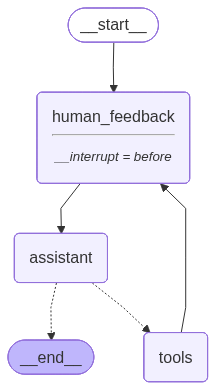

In [27]:
# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# no-op node that should be interrupted on
def human_feedback(state: MessagesState):
    pass

# Assistant node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))
builder.add_node("human_feedback", human_feedback)

# Define edges: these determine the control flow
builder.add_edge(START, "human_feedback")
builder.add_edge("human_feedback", "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "human_feedback")

memory = MemorySaver()
graph = builder.compile(interrupt_before=["human_feedback"], checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

### example 1

In [28]:
# Input
initial_input = {"messages": "factorial 2 and then multiply the answer with 4"}

# Thread
thread = {"configurable": {"thread_id": "5"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()
    
# Get user input
user_input = input("update the state: ")

# We now update the state as if we are the human_feedback node
graph.update_state(thread, {"messages": user_input}, as_node="human_feedback")

# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

factorial 2 and then multiply the answer with 4
================================ Human Message =================================

multiply 7 and 6
================================== Ai Message ==================================
Tool Calls:
  factorial (call_NkuhAxQonqV44Qg1BKEXGzmm)
 Call ID: call_NkuhAxQonqV44Qg1BKEXGzmm
  Args:
    n: 2
  multiply (call_NAVBOi7Hn9L9j0tcy9YDSjtM)
 Call ID: call_NAVBOi7Hn9L9j0tcy9YDSjtM
  Args:
    a: 7
    b: 6
================================= Tool Message =================================
Name: multiply

42


#### example 2

In [29]:
# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================= Tool Message =================================
Name: multiply

42
================================== Ai Message ==================================
Tool Calls:
  multiply (call_P7z5sMXJLvogOQOHBoZQ8wUu)
 Call ID: call_P7z5sMXJLvogOQOHBoZQ8wUu
  Args:
    a: 2
    b: 4
================================= Tool Message =================================
Name: multiply

8


In [30]:
# Input
initial_input = {"messages": "integer divide 80 by 3 and then add 28 to it "}

# Thread
thread = {"configurable": {"thread_id": "6"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()
    
# Get user input
user_input = input("update the state: ")

# We now update the state as if we are the human_feedback node
graph.update_state(thread, {"messages": user_input}, as_node="human_feedback")

# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

integer divide 80 by 3 and then add 28 to it 
================================ Human Message =================================

no calculate 8 factorial
================================== Ai Message ==================================
Tool Calls:
  integer_division (call_4SxBAQ9pJ1NHIIF5zyRbKLK3)
 Call ID: call_4SxBAQ9pJ1NHIIF5zyRbKLK3
  Args:
    a: 80
    b: 3
  factorial (call_1Y3l2UPp2oo6r38FhexolsJf)
 Call ID: call_1Y3l2UPp2oo6r38FhexolsJf
  Args:
    n: 8
================================= Tool Message =================================
Name: factorial

40320


In [31]:
# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================= Tool Message =================================
Name: factorial

40320
================================== Ai Message ==================================

The result of integer dividing 80 by 3 is 26. Additionally, the factorial of 8 is 40,320.
